In [1]:
from torchvision import models

In [3]:
# modelo
path = "/app/pytorch_luca/modelos/resnet101-63fe2227.pth"
resnet = models.resnet101() # resnet = models.resnet101(pretrained=True)
resnet.load_state_dict(torch.load(path))
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
from torchvision import transforms

In [5]:
preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225] )])

In [6]:
from PIL import Image

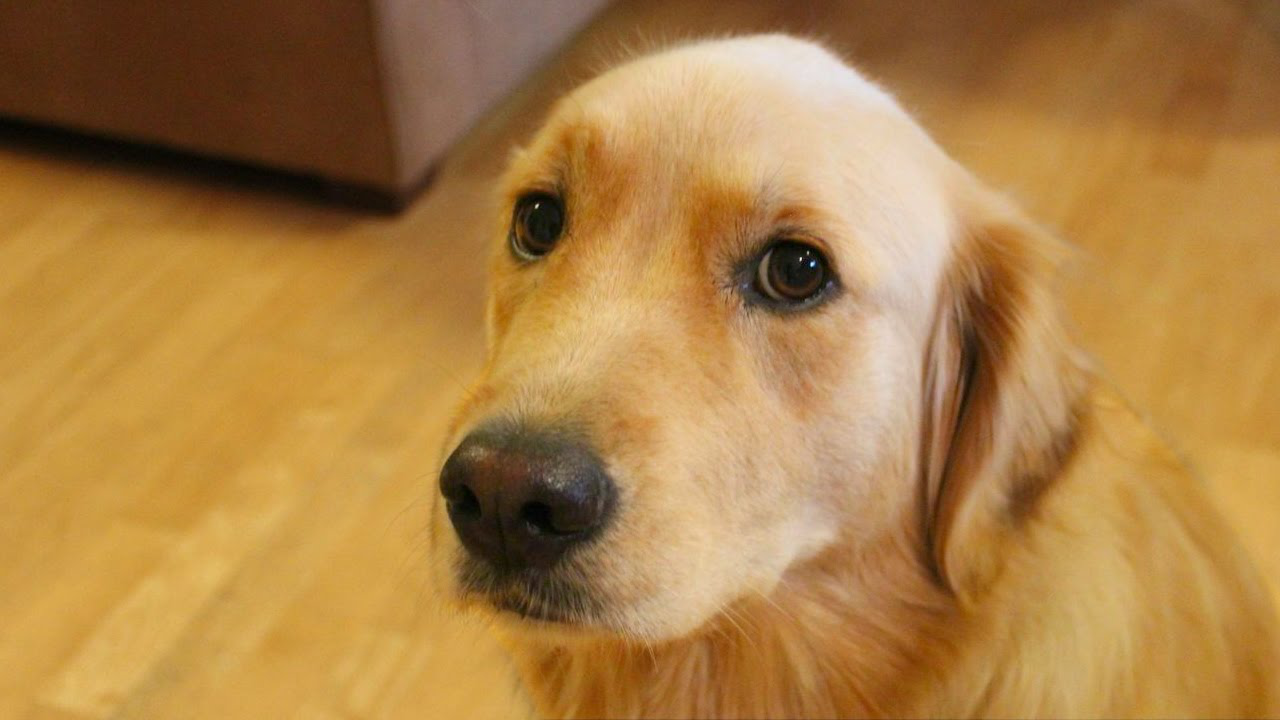

In [7]:
img = Image.open("/app/pytorch_luca/data/p1ch2/bobby.jpg")
img

In [9]:
img_t = preprocess(img)

In [10]:
import torch
batch_t = torch.unsqueeze(img_t, 0)

In [11]:
out = resnet(batch_t)
out

tensor([[-3.4803e+00, -1.6618e+00, -2.4515e+00, -3.2662e+00, -3.2466e+00,
         -1.3611e+00, -2.0465e+00, -2.5112e+00, -1.3043e+00, -2.8900e+00,
         -1.6862e+00, -1.3055e+00, -2.6129e+00, -2.9645e+00, -2.4300e+00,
         -2.8143e+00, -3.3019e+00, -7.9404e-01, -6.5182e-01, -1.2308e+00,
         -3.0193e+00, -3.9457e+00, -2.2675e+00, -1.0811e+00, -1.0232e+00,
         -1.0442e+00, -3.0918e+00, -2.4613e+00, -2.1964e+00, -3.2354e+00,
         -3.3013e+00, -1.8553e+00, -2.0921e+00, -2.1327e+00, -1.9102e+00,
         -3.2403e+00, -1.1396e+00, -1.0925e+00, -1.2186e+00, -9.3332e-01,
         -4.5093e-01, -1.5489e+00,  1.4161e+00,  1.0871e-01, -1.8442e+00,
         -1.4806e+00,  9.6227e-01, -9.9456e-01, -3.0060e+00, -2.7384e+00,
         -2.5798e+00, -2.0666e+00, -1.8022e+00, -1.9328e+00, -1.7726e+00,
         -1.3041e+00, -4.5848e-01, -2.0537e+00, -3.2804e+00, -5.0451e-01,
         -3.8174e-01, -1.1147e+00, -7.3998e-01, -1.4299e+00, -1.4883e+00,
         -2.1073e+00, -1.7373e+00, -4.

In [12]:
with open('/app/pytorch_luca//data/p1ch2/imagenet_classes.txt') as f:
    labels = [line.strip() for line in f.readlines()]

_, index = torch.max(out, 1)

In [13]:
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
labels[index[0]], percentage[index[0]].item()

('golden retriever', 96.29335021972656)

In [14]:
_, indices = torch.sort(out, descending=True)
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

[('golden retriever', 96.29335021972656),
 ('Labrador retriever', 2.808121681213379),
 ('cocker spaniel, English cocker spaniel, cocker', 0.28267431259155273),
 ('redbone', 0.20863044261932373),
 ('tennis ball', 0.11621593683958054)]

# Caballo a zebra

In [16]:
import torch.nn as nn

In [19]:
class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)

In [20]:
netG = ResNetGenerator()

In [22]:
model_path = 'app/pytorch_luca/data/p1ch2/horse2zebra_0.4.0.pth'
model_data = torch.load(model_path)
netG.load_state_dict(model_data)

<All keys matched successfully>

In [23]:
netG.eval()

ResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResNetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
     

In [24]:
preprocess = transforms.Compose([transforms.Resize(256),
                                transforms.ToTensor()])

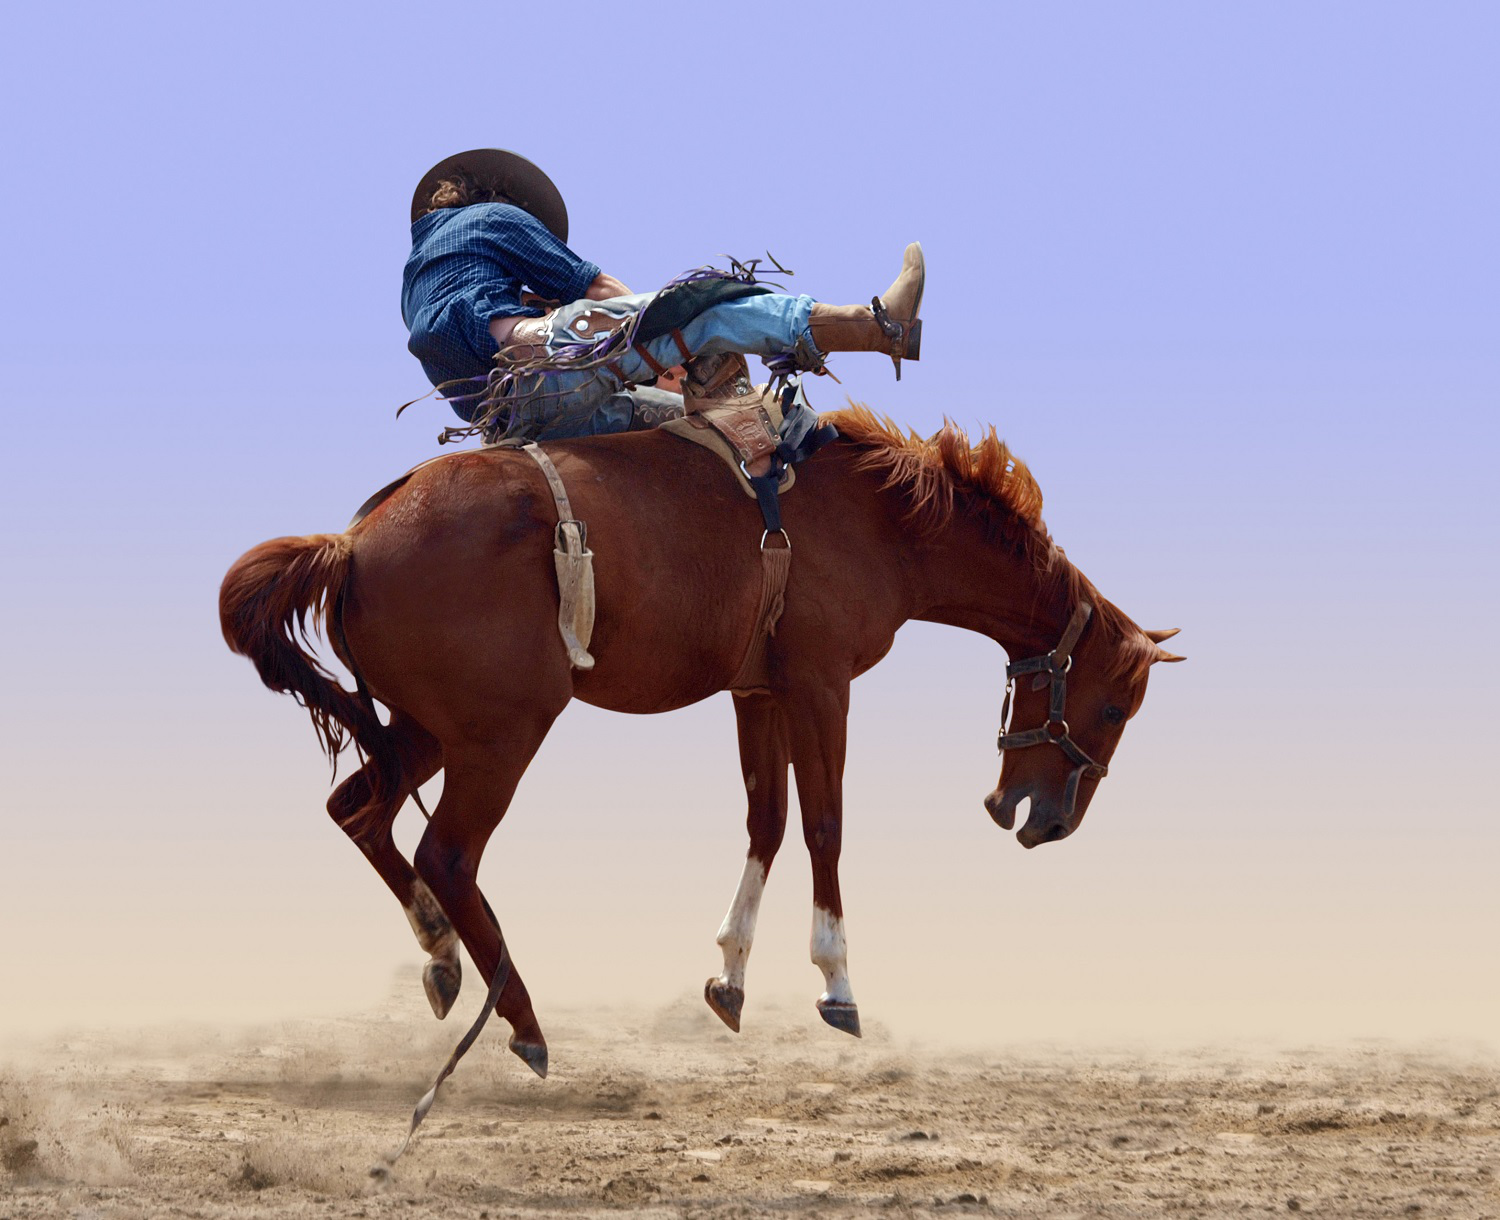

In [25]:
img = Image.open("app/pytorch_luca/data/p1ch2/horse.jpg")
img

In [26]:
img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0)

In [27]:
batch_out = netG(batch_t)

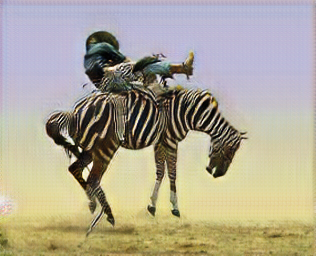

In [28]:
out_t = (batch_out.data.squeeze() + 1.0) / 2.0
out_img = transforms.ToPILImage()(out_t)
out_img

# 3 Starts with a tensor

In [31]:
img_t = torch.randn(3, 5, 5)
img_gray_naive = img_t.mean(-3)
batch_gray_naive = batch_t.mean(-3)
img_gray_naive.shape, batch_gray_naive.shape

(torch.Size([5, 5]), torch.Size([2, 5, 5]))